In [1]:
#Import Data prep/processing packages
import numpy as np
import pandas as pd
import re
import statistics as stat

#import plotting packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#import machine learning packages
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MultiLabelBinarizer

#set float format to 2 decimal places
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Introduction

An Airbnb host in the San Francisco Bay Area is likely paying a premium in housing costs. Therefore, maximizing price is a priority in order to realize a profit from their listings. To maximize the price, a host may ask, "What Airbnb listing features are important?", "What amenities should I offer?", and "What size, room type, and location will maximize my profit?". Using Airbnb Listings data from http://insideairbnb.com/get-the-data/, this analysis utilizes the CRISP-DM Data Science process to help the Airbnb host answer those questions.

# Data Understanding and Preparation

In [2]:
#import listings as dataframe, "listings"
df_raw = pd.read_csv('./listings.csv')

First off, we want to focus on listings that have reviews. It's easy to post a listing on Airbnb without having a review, so focusing on those with just reviews gives us more confidence that the price is accurate for what the accommodations are worth.

In [3]:
#Determine what percent of listings have a review. Drop those without a review since features of hosts with reviews will be more predictive of price.
no_reviews = df_raw['review_scores_rating'].isnull().mean()*100
df = df_raw.dropna(how = 'any', subset = ['review_scores_rating'])  #drop listings with no reviews
print('%f percent of listings do not have any reviews.' %no_reviews)

20.832684 percent of listings do not have any reviews.


In [4]:
#Convert price to number and get descriptive statistics of price
df.loc[:,('price')] = df.loc[:,('price')].replace('[\$,]','',regex = True).astype(float) #convert price to float, remove $
df['price'].describe()

/Users/andrewwrist/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


count    5077.00
mean      210.71
std       435.80
min         0.00
25%        95.00
50%       145.00
75%       227.00
max     25000.00
Name: price, dtype: float64

Max price of $25,000? Wow. This is obviously an outlier--especially considering the mean of $435.80 and std of $435.80. We will take care of these outliers and get rid of the free listings with the next steps.

In [5]:
#Remove $0 price from data frame
df = df[df['price']>0].reset_index() #keep only prices above $0
df['price'].describe()

count    5076.00
mean      210.76
std       435.83
min        10.00
25%        95.00
50%       145.00
75%       227.00
max     25000.00
Name: price, dtype: float64

The outliers cause an obvious skew to the dataset, and this is very apparent with the following histogram plots for price and log(price). Log(price) helps a bit, but still doesn't give that normal distribution that will help us out with our machine learning algorithms later on.

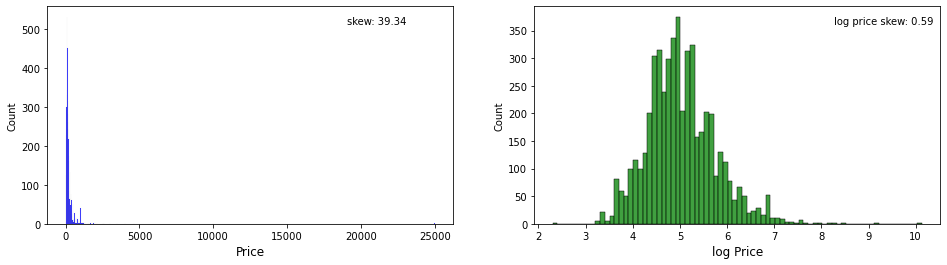

In [6]:
def plot_skew(col):
    '''
    Plot normal distribution and calculate skew for price column in dataset
    '''
    #Since we will be aiming for a normal distribution to make our predictions using linear regression, we must reduce the skewness. 
    price_skew = col.skew(axis = 0, skipna = True) #calculate skew of price
    logprice_skew = (np.log(col)).skew(axis = 0, skipna = True) #calculate log of price

    #plot price and log price distributions
    fig, ax =plt.subplots(1, 2, figsize=(16,4))
    chart1 = sns.histplot(col, ax=ax[0], color='b')
    chart1.set_xlabel('Price',fontsize=12)
    chart1.annotate(text=f'skew: {price_skew:.2f}', xy=(300, 200), xycoords='axes points')
    chart2 = sns.histplot(np.log(col), ax=ax[1], color='g')
    chart2.set_xlabel('log Price',fontsize=12)
    chart2.annotate(text=f'log price skew: {logprice_skew:.2f}', xy=(300, 200), xycoords='axes points')
    
plot_skew(df['price'])

In [7]:
#Remove outliers from price and get summary details
df = df[df['price']<(df['price'].mean()+stat.stdev(df['price']))].reset_index() #remove outlier prices
price = df['price']
price.describe()

count   4888.00
mean     171.70
std      112.70
min       10.00
25%       94.00
50%      139.00
75%      215.00
max      625.00
Name: price, dtype: float64

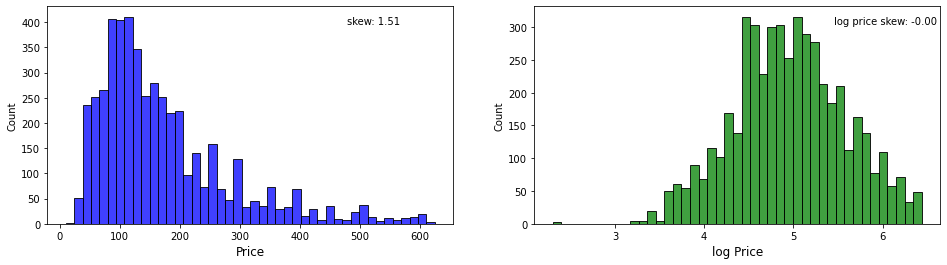

In [8]:
#plot price and calculate skew for price dataset with outliers removed
plot_skew(df['price'])

As you can see, after removing outliers, the price distribution looks much better. Especially with the log(price). We'll set these aside and save them for our response variable for later use.

In [9]:
#Assign y and y_log to be used in machine learning models later
y = price
y_log = np.log(price)  #log of price

In [10]:
#Remove % from rate columns
df['host_response_rate'] = df['host_response_rate'].replace('[\%,]','',regex = True).astype(float)
df['host_acceptance_rate'] = df['host_acceptance_rate'].replace('[\%,]','',regex = True).astype(float)

In [11]:
qty_listings = df.shape[0]
qty_columns = df.shape[1]
qty_hosts = len(df['host_id'].unique())
as_of_date = df['last_scraped'].max()
print('The dataset is composed of data for %d listings and %d variables from %d unique hosts in San Francisco as of %s.' 
      % (qty_listings, qty_columns, qty_hosts, as_of_date))

The dataset is composed of data for 4888 listings and 76 variables from 2778 unique hosts in San Francisco as of 12/4/21.


Next, let's create a second version of our dataframe with just the features we think will be important to the study. 

In [12]:
#Select important variables to be used in study
df2 = df[['last_scraped', 'name', 'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_listings_count',
       'host_total_listings_count', 'host_has_profile_pic',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'number_of_reviews', 'review_scores_rating',
        'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value','instant_bookable','reviews_per_month']]

In [13]:
#determine what percent of values are missing from dataset for different features
df_pcnt_missing = df2.isnull().mean()*100 #calculates percent nans in each column
df_missing = df_pcnt_missing[df_pcnt_missing>0]
df_missing.sort_values(ascending = False)

neighbourhood_group_cleansed   100.00
bathrooms                      100.00
host_response_time              21.24
host_response_rate              21.24
host_acceptance_rate            17.47
bedrooms                        13.95
beds                             3.66
review_scores_location           0.57
review_scores_checkin            0.57
review_scores_value              0.57
review_scores_accuracy           0.55
review_scores_cleanliness        0.55
review_scores_communication      0.55
bathrooms_text                   0.14
host_has_profile_pic             0.04
host_total_listings_count        0.04
host_listings_count              0.04
host_is_superhost                0.04
dtype: float64

There are two features with 100% missing values. We will go ahead and remove those.

In [14]:
#Print quantity of columns with missing data
qty_nan_cols = df_missing.shape[0]
print('There are %d columns with nan values.' %qty_nan_cols)

There are 18 columns with nan values.


In [15]:
#Drop columns with more than % missing values specified
pcnt_missing_thresh = 0.75  #establish threshold for number of missing values that is acceptable
df2_pcnt_missing_thresh = set(df2.columns[df2.isnull().mean()>pcnt_missing_thresh])
df2 = df2.drop(df2_pcnt_missing_thresh,axis  = 1)

Next up, we will separate out the airbnb_name and amenities features to apply some natural language processing and separate out individual amenities and name words. We'll leave the remaining categorical data in its own, one-hot-encoded dataframe.

In [16]:
#create categories dataframe
cat_df = df2.select_dtypes(include=['object']) 
cat_df = cat_df.drop('last_scraped',axis = 1)
airbnb_name = cat_df['name']  #separate out airbnb name
amenities = cat_df['amenities']  #separate out amenities
cat_df = cat_df.drop(['name','amenities'],axis = 1)  #drop airbnb name, amenities, and price from categories dataframe

#fill nan cat columns with modes
fill_mode = lambda col: col.fillna(col.mode()[0])
cat_df = cat_df.apply(fill_mode, axis=0)

#one-hot encode for cat variables
cat_one_hot = pd.get_dummies(cat_df, columns = cat_df.columns)
cat_one_hot_sums = cat_one_hot.sum()>cat_one_hot.shape[1]/8  #keep features with more than 1/8 response
cat_one_hot_thresh = (set(cat_one_hot.columns[cat_one_hot.sum()<cat_one_hot.shape[1]/8]))
cat_one_hot = cat_one_hot.drop(cat_one_hot_thresh,axis  = 1)
cat_one_hot

,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_is_superhost_f,host_is_superhost_t,host_has_profile_pic_t,neighbourhood_cleansed_Bayview,neighbourhood_cleansed_Bernal Heights,neighbourhood_cleansed_Castro/Upper Market,...,bathrooms_text_10 shared baths,bathrooms_text_2 baths,bathrooms_text_2 shared baths,bathrooms_text_2.5 baths,bathrooms_text_2.5 shared baths,bathrooms_text_3 baths,bathrooms_text_4 shared baths,bathrooms_text_5 shared baths,instant_bookable_f,instant_bookable_t
0,0,0,1,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,1,0,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3,0,0,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,0,0,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4883,0,0,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4884,0,0,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4885,0,0,0,1,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
4886,0,0,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


The amenities feature is essentially a list of lists. Each individual list contains amenities separated by a comma. The following code separates these amenities and uses MultiLabelBinarizer to set up a one-hot-encoded dataframe for each individual amenity. Since there are many many amenities, we only took the top 60 (multiple iterations pointed to 60 being the magic number for maximizing our R-Squared value later on).

In [17]:
#Create Amenities dataframe and convert amenities list of lists to a dataframe with amenities as columns
amenities_dict = {}
amenities = amenities.replace('[\[]','',regex = True).replace('[\]]','',regex = True).replace('[\"]','',regex = True)
amenities_list = amenities.to_list()
for amenities_list in amenities:
    for amenity in amenities_list.split(', '):
        if amenity in amenities_dict:
            amenities_dict[amenity] = amenities_dict[amenity] + 1
        else:
            amenities_dict[amenity] = 0
amenities_sorted = sorted(amenities_dict.items(), key=lambda x: x[1], reverse=True)

#narrow amenities to the top 60 most listed amenities
top_amenities = amenities_sorted[0:60]
top_amenities_df = pd.DataFrame(top_amenities)
top_amenities_list = top_amenities_df[0]

#Create amenities one hot encoded DF using MultiLabelBinarizer
amenities_list = amenities.to_list()
s = pd.Series(amenities_list)
mlb = MultiLabelBinarizer()
a = mlb.fit_transform(s.str.split(', '))
amenities_one_hot = pd.DataFrame(a, columns=mlb.classes_ )
amenities_one_hot = amenities_one_hot[top_amenities_list]

Similar to the amenities dataframe, I broke the Airbnb names out into their individual words, separated by spaces, and one-hot-encoded the most frequently used names. I included a step to take out the obvious stop words and things like "Francisco" and "bedroom".

In [18]:
#airbnb name processing to lower case and get rid of special characters
airbnb_name_df = airbnb_name.to_frame()
airbnb_name_reg = airbnb_name_df.applymap(lambda x: re.sub('[!,*)@#%(&$_?.^-]', '', x))  #remove special characters
airbnb_name_lower = airbnb_name_reg['name'].str.lower()


#Get most frequenty used airbnb title name words excluding words that we don't want to see
airbnb_name_list =  airbnb_name_lower.to_list()
name_dict = {}
for airbnb_name_list in airbnb_name_lower:
    for name_word in airbnb_name_list.split(' '):
        #Check if word is in name and is not one of the commonly used words
        if name_word in name_dict and name_word not in ['in','a','by','with','','room','the','bedroom','sf','san','w/','francisco','2','of','1','and','to']:
            name_dict[name_word] = name_dict[name_word] + 1
        else:
            name_dict[name_word] = 0

#sort name dictionary and return only those that were used more than 300 times.
airbnb_name_sorted = sorted(name_dict.items(), key=lambda x: x[1], reverse=True)
airbnb_name_sorted_df = pd.DataFrame(airbnb_name_sorted)
airbnb_name_sorted_df_top = airbnb_name_sorted_df[airbnb_name_sorted_df[1]>300] #return names used more than 300 times

#Create airbnb names one hot encoded DF using MultiLabelBinarizer
airbnb_name_list =  airbnb_name_lower.to_list()
s = pd.Series(airbnb_name_list)
mlb = MultiLabelBinarizer()
a = mlb.fit_transform(s.str.split(' '))
airbnb_name_one_hot = pd.DataFrame(a, columns=mlb.classes_ )
top_names_list = airbnb_name_sorted_df_top[0]
name_one_hot = airbnb_name_one_hot[top_names_list].add_prefix('name_')

Next, I pulled out the numeric variables and filled nans with the mean. I tried both mode and mean, and mean gave us a slightly higher R-Squared value.

In [19]:
#pull numeric variables from reduced dataframe
num_vars = df2.select_dtypes("number")

#fill mean values for numeric variables with missing values
fill_mean = lambda col: col.fillna(col.mean())
# Fill the mean
fill_num_vars = num_vars.apply(fill_mean, axis=0)

I took a subset of the numeric variables and created a correlation heatmap to see if any obvious correlations stood out. As expected, beds, bedrooms, and accommodates were all correlated with price. Everything else was somewhat negligible, at least on the surface.

/var/folders/dz/71j5m95x01d2wwbm3pz62vz80000gn/T/ipykernel_4887/2426596650.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num_vars_sub['price'] = price


<AxesSubplot:>

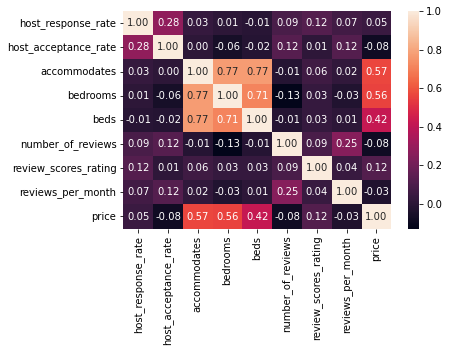

In [20]:
#Create heatmap for important numeric variables
num_vars_sub = fill_num_vars[['host_response_rate', 'host_acceptance_rate', 'accommodates', 'bedrooms', 'beds',
       'number_of_reviews', 'review_scores_rating','reviews_per_month']]
num_vars_sub['price'] = price
sns.heatmap(num_vars_sub.corr(), annot=True, fmt = '.2f')

In [21]:
#Combine dataframes to be used in the machine learning analysis
frames = [fill_num_vars, name_one_hot, amenities_one_hot, cat_one_hot]
X = pd.concat(frames, axis = 1)

Finally, the data prep is done! Now on to Data Modeling.

# Data Modeling

In [22]:
def linear_regression(X, y):
    '''
    Function to develop a linear regression model for inputs X (features) and y (response)
    Returns test and training R-Squared scores, X_train, X_test, y_train, y_test, and predictions
    '''
    #train linear regression model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

    lm_model = LinearRegression(normalize=True) # Instantiate
    lm_model.fit(X_train, y_train) #Fit

    #Predict and score the model
    y_test_preds = lm_model.predict(X_test) 
    y_train_preds = lm_model.predict(X_train)
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)
    return test_score, train_score, lm_model, X_train, X_test, y_train, y_test, y_train_preds, y_test_preds


#Test function with the above dataset
test_score, train_score, lm_model, X_train, X_test, y_train, y_test, y_train_preds, y_test_preds = linear_regression(X, y_log) #change y with y_log to see improvement

#print scores for the model
print('Linear Regression R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_preds),
        r2_score(y_test, y_test_preds)))

Linear Regression R^2 train: 0.679, test: 0.633


In [23]:
#function for random forest regressor
def random_forest(X, y):
    '''
    Function to develop a Random Forest Regressor model for inputs X (features) and y (response)
    Returns test and training R-Squared scores, X_train, X_test, y_train, y_test, and predictions
    '''
    #train random forest model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)
    forest = RandomForestRegressor(n_estimators = 200,
                                   criterion = 'mse',
                                   random_state = 42, 
                                   n_jobs = -1)
    #fit random forest model
    forest.fit(X_train, y_train.squeeze())

    #calculate y predictions
    y_train_preds = forest.predict(X_train)
    y_test_preds = forest.predict(X_test)

    return test_score, train_score, forest, X_train, X_test, y_train, y_test, y_train_preds, y_test_preds

#Test function with above dataset
test_score, train_score, forest, X_train, X_test, y_train, y_test, y_train_preds, y_test_preds = random_forest(X, y_log)

#print scores for the model
print('Random Forest R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_preds),
        r2_score(y_test, y_test_preds)))

Random Forest R^2 train: 0.957, test: 0.676


After running both Linear Regression and Random Forest for both Price and Log(price), Random Forest returned results with the least error. Now we can move on to further Result Evaluation and analysis.

# Result Evaluation and Analysis

In [24]:
def feature_importance(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the random forest model
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a random forest model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = forest.feature_importances_
    coefs_df['abs_coefs'] = np.abs(forest.feature_importances_)
#     coefs_df['coefs'] = lm_model.coef_  #use these for linear model
#     coefs_df['abs_coefs'] = np.abs(lm_model.coef_)  #use these for linear model
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = feature_importance(lm_model.coef_, X_train)

#A quick look at the top 10 results
coef_df.head(10)

,est_int,coefs,abs_coefs
5,bedrooms,0.28,0.28
4,accommodates,0.13,0.13
10,review_scores_cleanliness,0.04,0.04
134,property_type_Private room in residential home,0.03,0.03
13,review_scores_location,0.03,0.03
15,reviews_per_month,0.03,0.03
7,number_of_reviews,0.03,0.03
74,Air conditioning,0.02,0.02
1,host_acceptance_rate,0.02,0.02
146,bathrooms_text_1 bath,0.02,0.02


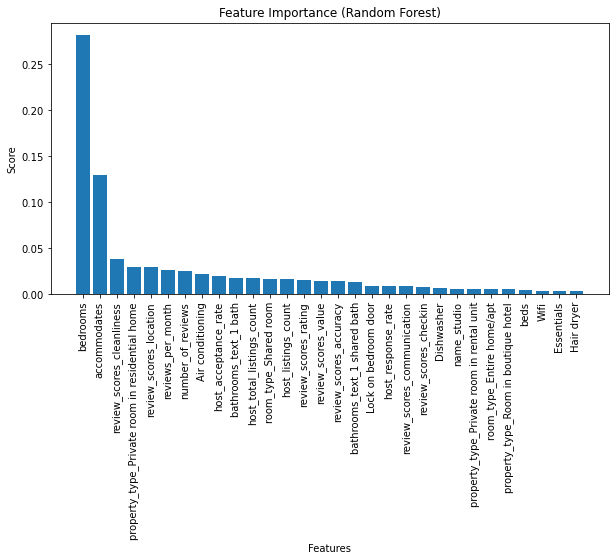

In [25]:
def plot_feature_importance(qty_features):
    '''
    Plots feature importance for random forest model with input of the quantity of features the user would like to generate
    '''
    #plot feature importances
    features = coef_df['est_int'][:qty_features]
    top_scores = coef_df['abs_coefs'][:qty_features]
    y_pos = np.arange(len(features))

    plt.figure(figsize=(10,5))
    plt.bar(features, top_scores)
    plt.xticks(y_pos, features, rotation='vertical')
    plt.ylabel('Score')
    plt.xlabel('Features')
    plt.title('Feature Importance (Random Forest)')

    plt.show()
    return

plot_feature_importance(30)

Plotting feature importance for the Random Forest output gave us some interesting insights into what variables bubbled up to the top. As expected, bedrooms and accommodates came out in front, as we would expect size to be correlated to price. However, there were some interesting amenities that seem to play in the mix in predicting price, as well as some other features. Those will be explored more in the following steps.

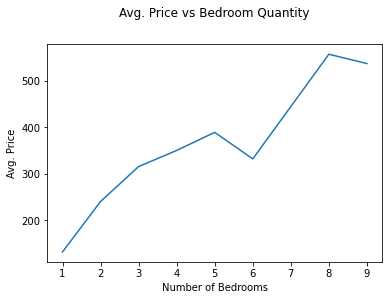

   bedrooms  price
0      1.00 132.01
1      2.00 240.53
2      3.00 315.52
3      4.00 350.22
4      5.00 389.09
5      6.00 332.00
6      8.00 557.00
7      9.00 537.00


In [26]:
#Plot avg price vs bedroom quantity and print average price for each grouping
average_price = df.groupby(df['bedrooms'], as_index = False)['price'].mean() #group bedroom qty by average price
plt.plot(average_price['bedrooms'], average_price['price'])
plt.xlabel('Number of Bedrooms')
plt.ylabel('Avg. Price')
plt.title('Avg. Price vs Bedroom Quantity', y=1.1)
plt.show()
print(average_price)

Avg price increases with number of bedrooms. Makes sense. It gets a little more interesting with the next plot of Avg price/bedroom vs Bedroom Quantity. Interesting stats to take into consideration if one is trying to determine the optimal number of bedrooms to list.

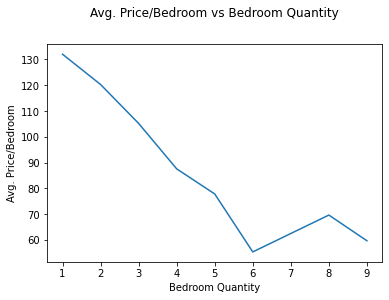

,bedrooms,price
0,1.00,132.01
1,2.00,240.53
2,3.00,315.52
3,4.00,350.22
4,5.00,389.09
5,6.00,332.00
6,8.00,557.00
7,9.00,537.00


In [27]:
#Plot avg price/bedroom vs bedroom quantity and print average price for each grouping
average_price = df.groupby(df['bedrooms'], as_index = False)['price'].mean() #group bedroom qty by average price
plt.plot(average_price['bedrooms'], average_price['price']/average_price['bedrooms'])
plt.xlabel('Bedroom Quantity')
plt.ylabel('Avg. Price/Bedroom')
plt.title('Avg. Price/Bedroom vs Bedroom Quantity', y=1.1)
plt.show()
average_price

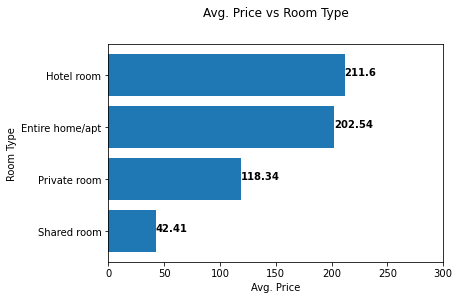

In [28]:
average_price = df.groupby(df['room_type'], as_index = False)['price'].mean().sort_values(by = ['price'])
plt.barh(average_price['room_type'], average_price['price'])
# plt.barh(average_price['neighbourhood_cleansed'], average_price['price'])
for i, v in enumerate(average_price['price']):
    plt.text(v, i, round(v,2), fontweight='bold')
plt.xlim(0,300)
plt.xlabel('Avg. Price')
plt.ylabel('Room Type')
plt.title('Avg. Price vs Room Type', y=1.1)
plt.show()

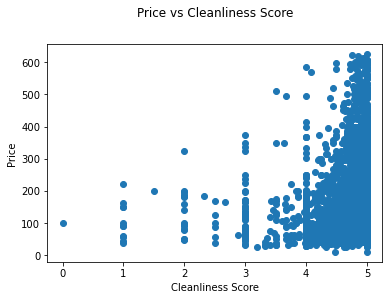

In [29]:
# average_price = df.groupby(df['bedrooms'], as_index = False)['price'].mean()
plt.scatter(df['review_scores_cleanliness'], df['price'])
plt.xlabel('Cleanliness Score')
plt.ylabel('Price')
plt.title('Price vs Cleanliness Score', y=1.1)
plt.show()

While not super obvious, there is certainly an apparent trend that higher priced accommodations tend to have higher cleanliness scores. Especially when the price gets over $400/night.

Now let's take a look into amenities...

In [30]:
#Prep amenities data to be plotted with "Yes" and "No" values rather than 1 or 0
amenities_cat = amenities_one_hot.replace(1,'Yes')
amenities_cat = amenities_cat.replace(0,'No')

amenities_price = [price, amenities_cat]
amenities_price = pd.concat(amenities_price, axis = 1)

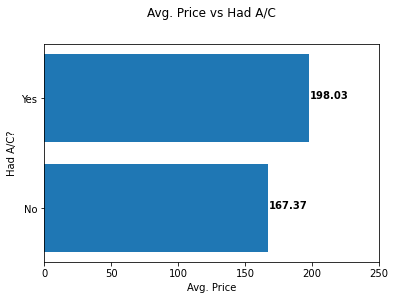

In [31]:
average_price = amenities_price.groupby(amenities_price['Air conditioning'], as_index = False)['price'].mean().sort_values(by = ['price'], ascending = False)
top10_average_price = average_price.head(10).sort_values(by = ['price'])
plt.barh(top10_average_price['Air conditioning'], top10_average_price['price'])
# plt.barh(average_price['neighbourhood_cleansed'], average_price['price'])
for i, v in enumerate(top10_average_price['price']):
    plt.text(v, i, round(v,2), fontweight='bold')
plt.xlim(0,250)
plt.xlabel('Avg. Price')
plt.ylabel('Had A/C?')
plt.title('Avg. Price vs Had A/C', y=1.1)
plt.show()

While only 47% of houses in the bay area have A/C, it still seems to be valuable at an additional $31/night!

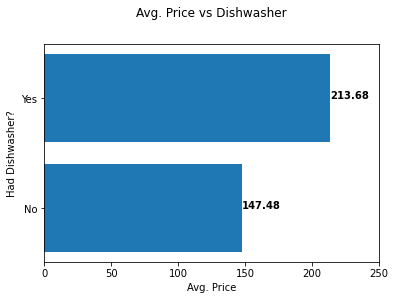

In [32]:
average_price = amenities_price.groupby(amenities_price['Dishwasher'], as_index = False)['price'].mean().sort_values(by = ['price'], ascending = False)
top10_average_price = average_price.head(10).sort_values(by = ['price'])
plt.barh(top10_average_price['Dishwasher'], top10_average_price['price'])
# plt.barh(average_price['neighbourhood_cleansed'], average_price['price'])
for i, v in enumerate(top10_average_price['price']):
    plt.text(v, i, round(v,2), fontweight='bold')
plt.xlim(0,250)
plt.xlabel('Avg. Price')
plt.ylabel('Had Dishwasher?')
plt.title('Avg. Price vs Dishwasher', y=1.1)
plt.show()

Never would have guessed that dishwashers were valued so highly. I guess no one likes to do dishes! You might think this is correlated with accommodations having kitchens, but kitchens did not show up as an important feature, and the below plot indicates they're not quite as big of a price booster as dishwashers.

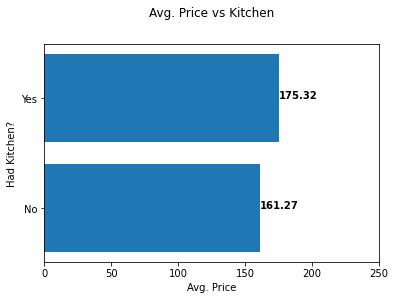

In [33]:
average_price = amenities_price.groupby(amenities_price['Kitchen'], as_index = False)['price'].mean().sort_values(by = ['price'], ascending = False)
top10_average_price = average_price.head(10).sort_values(by = ['price'])
plt.barh(top10_average_price['Kitchen'], top10_average_price['price'])
# plt.barh(average_price['neighbourhood_cleansed'], average_price['price'])
for i, v in enumerate(top10_average_price['price']):
    plt.text(v, i, round(v,2), fontweight='bold')
plt.xlim(0,250)
plt.xlabel('Avg. Price')
plt.ylabel('Had Kitchen?')
plt.title('Avg. Price vs Kitchen', y=1.1)
plt.show()

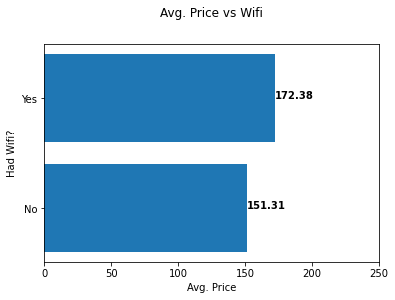

In [34]:
average_price = amenities_price.groupby(amenities_price['Wifi'], as_index = False)['price'].mean().sort_values(by = ['price'], ascending = False)
top10_average_price = average_price.head(10).sort_values(by = ['price'])
plt.barh(top10_average_price['Wifi'], top10_average_price['price'])
# plt.barh(average_price['neighbourhood_cleansed'], average_price['price'])
for i, v in enumerate(top10_average_price['price']):
    plt.text(v, i, round(v,2), fontweight='bold')
plt.xlim(0,250)
plt.xlabel('Avg. Price')
plt.ylabel('Had Wifi?')
plt.title('Avg. Price vs Wifi', y=1.1)
plt.show()

Wifi is imporant. Especially in the tech capital of the world.

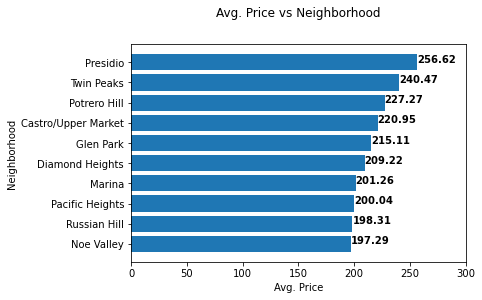

In [35]:
average_price = df.groupby(df['neighbourhood_cleansed'], as_index = False)['price'].mean().sort_values(by = ['price'], ascending = False)
top10_average_price = average_price.head(10).sort_values(by = ['price'])
plt.barh(top10_average_price['neighbourhood_cleansed'], top10_average_price['price'])
# plt.barh(average_price['neighbourhood_cleansed'], average_price['price'])
for i, v in enumerate(top10_average_price['price']):
    plt.text(v, i, round(v,2), fontweight='bold')
plt.xlim(0,300)
plt.xlabel('Avg. Price')
plt.ylabel('Neighborhood')
plt.title('Avg. Price vs Neighborhood', y=1.1)
plt.show()

Even though neighborhood didn't make the list of top 30 features for predicting price, there is still value in the neighborhood! These are just the top 10, but there is a significant price jump between them.

# Conclusion/Deployment

In this analysis, we took a look at how one can become a more successful Airbnb host and maximize the price of their listing, using a data-driven approach. 
We gathered data from over 6,000 listings in San Francisco and identified the 30 most important features from those listings.
We then looked at what amenities will enable them to boost their price the most and by how much.
Finally, we looked at what size, housing type, and location is best for hosting thir Airbnb, as well as some other interesting features.

This analysis was inspired by a project as part of the Data Science Nanodegree I am currently pursuing through Udacity. I used my findings and graphics from here to write an article on Medium titled, "How Do YOU Become A Successful Airbnb Host In San Francisco?" I plan to continue refining my code and making improvements to my machine learning process as I continue learning more. Thanks for reading!